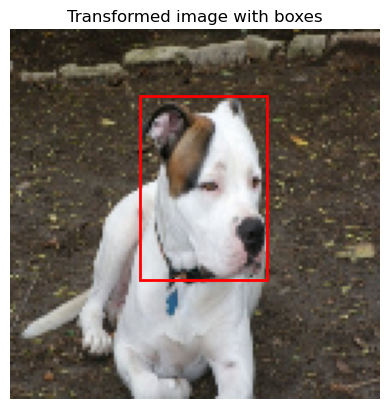

Image shape: torch.Size([3, 128, 128])
Target: {'boxes': tensor([[44.5440, 22.5280, 88.5760, 86.3573]]), 'labels': tensor([2])}
 Training 

 New best model saved.
Epoch 1 loss: 33.213 , val match: 92.00%
Epoch 2 loss: 22.972 , val match: 88.00%

 Best accuracy: 92.00%


In [140]:
import os
import torch
import xml.etree.ElementTree as ET
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import torchvision.transforms.functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time

writer = SummaryWriter(log_dir=f"runs/FasterRCNN_{int(time.time())}")
CLASS_MAP = {"cat": 1, "dog": 2}

class PetDetectionDataset(Dataset):
    def __init__(self, root):
        self.root = root
        self.img_dir = os.path.join(root, "images")
        self.ann_dir = os.path.join(root, "annotations/xmls")
        # get list of all annotation files (remove '.xml' extension)
        self.samples = [f[:-4] for f in os.listdir(self.ann_dir) if f.endswith(".xml")]
         # define image augmentations using Albumentations
        self.aug = A.Compose([
            A.Resize(128, 128),# resize to 128x128
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2() # convert to PyTorch tensor
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))# tell albumentations to expect Pascal VOC format for boxes and match them to the labels

    def __len__(self):
        return len(self.samples) # Total number of samples

    def __getitem__(self, idx):
        file_id = self.samples[idx]  # base filename 
         # Build full image and XML annotation paths
        img_path = os.path.join(self.img_dir, file_id + ".jpg")
        xml_path = os.path.join(self.ann_dir, file_id + ".xml")
        # Load image using PIL and convert to RGB
        img = Image.open(img_path).convert("RGB")
        # Parse XML file to get annotations
        root = ET.parse(xml_path).getroot()

        boxes, labels = [], [] # Initialize empty lists for boxes and labels
        # Iterate over each object in the annotation
        for obj in root.findall("object"):
            name = obj.find("name").text.lower().strip()# Get the object class name
            if "cat" in name:
                labels.append(1)
            elif "dog" in name:
                labels.append(2)
             # Extract bounding box coordinates from XML
            bb = obj.find("bndbox")
            coords = [
                int(bb.find("xmin").text),
                int(bb.find("ymin").text),
                int(bb.find("xmax").text),
                int(bb.find("ymax").text)
            ]
            boxes.append(coords)
         # Apply augmentations (image, bounding boxes, and labels)
        transformed = self.aug(image=np.array(img), bboxes=boxes, labels=labels)
        x = transformed["image"]
        y = {
            "boxes": torch.tensor(transformed["bboxes"], dtype=torch.float32),
            "labels": torch.tensor(transformed["labels"], dtype=torch.int64)
        }
        return x, y
# Define the model architecture
def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, num_classes)
    return model
# Compute iou between two boxes
def iou(box1, box2):
    xa1, ya1, xa2, ya2 = box1
    xb1, yb1, xb2, yb2 = box2
    # Calculate intersection area
    inter_w = max(0, min(xa2, xb2) - max(xa1, xb1))
    inter_h = max(0, min(ya2, yb2) - max(ya1, yb1))
    inter_area = inter_w * inter_h
    # Calculate union area
    area1 = (xa2 - xa1) * (ya2 - ya1)
    area2 = (xb2 - xb1) * (yb2 - yb1)
    union = area1 + area2 - inter_area
    return inter_area / union if union > 0 else 0

def validate(model, loader, device, writer, epoch):
    val_loss = 0.0
    model.eval()
    matched, total = 0, 0

    with torch.no_grad():# Disable gradients for validation
        for images, targets in loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            preds = model(images)# Run inference
            # Evaluate loss on the validation batch
            model.train()
            loss_dict = model(images, targets)
            model.eval()
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
             # Compare predictions to ground truth
            for pred, truth in zip(preds, targets):
                pb, pl = pred["boxes"].cpu(), pred["labels"].cpu()
                tb, tl = truth["boxes"].cpu(), truth["labels"].cpu()

                for i in range(len(tb)):
                    for j in range(len(pb)):
                        if pred["scores"][j] < 0.3:# skip low confidence predictions
                            continue
                        if iou(tb[i], pb[j]) > 0.5 and tl[i] == pl[j]:
                            matched += 1
                            break
                total += len(tb)
    # Log average loss and accuracy to TensorBoard
    avg_val_loss = val_loss / len(loader)
    accuracy = matched / total if total > 0 else 0.0

    writer.add_scalar("Loss/val", avg_val_loss, epoch)
    writer.add_scalar("Accuracy/val", accuracy, epoch)
    return accuracy

# Main

if __name__ == "__main__":
    data = PetDetectionDataset("dataset")
    split = torch.randperm(len(data)).tolist()
    train_ds = Subset(data, split[:250])
    val_ds = Subset(data, split[250:300])
    
    # Define DataLoaders 
    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=lambda b: tuple(zip(*b)))
    val_loader = DataLoader(val_ds, batch_size=4, collate_fn=lambda b: tuple(zip(*b)))

    # Visualize a sample image with boxes
    vis_loader = DataLoader(data, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
    images, targets = next(iter(vis_loader))
    img = images[0]
    target = targets[0]
    # Undo normalization for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_vis = img * std + mean
    img_vis = torch.clamp(img_vis, 0, 1)
    # Convert tensor to PIL image
    img_pil = F.to_pil_image(img_vis)

    fig, ax = plt.subplots(1)
    ax.imshow(img_pil)

    for box in target["boxes"]:
        xmin, ymin, xmax, ymax = box.tolist()
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    plt.axis("off")
    plt.title("Transformed image with boxes")
    plt.show()
    print("Image shape:", img.shape)
    print("Target:", target)
    

    # Set up device and model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_model(num_classes=3).to(device)
    # Optimizer and learning rate scheduler
    opt = torch.optim.SGD([p for p in model.parameters() if p.requires_grad], lr=0.005, momentum=0.9, weight_decay=0.0005)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.1)

    print(" Training \n")
    top_score = 0.0
    train_losses = []
    val_accuracies = []

    for epoch in range(2):
        model.train()
        total_loss = 0.0

        for x, y in train_loader:
            x = [img.to(device) for img in x]
            y = [{k: v.to(device) for k, v in t.items()} for t in y]

            opt.zero_grad()
            loss_dict = model(x, y)
            loss = sum(loss_dict.values())
            loss.backward()
            opt.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        writer.add_scalar("Loss/train", avg_loss, epoch)
        scheduler.step()

        score = validate(model, val_loader, device, writer, epoch)
        train_losses.append(total_loss)
        val_accuracies.append(score)
         # Save model if validation score improves
        if score > top_score:
            top_score = score
            torch.save(model.state_dict(), "model_best.pth")
            print(" New best model saved.")

        print(f"Epoch {epoch+1} loss: {total_loss:.3f} , val match: {score:.2%}")

    print(f"\n Best accuracy: {top_score:.2%}")


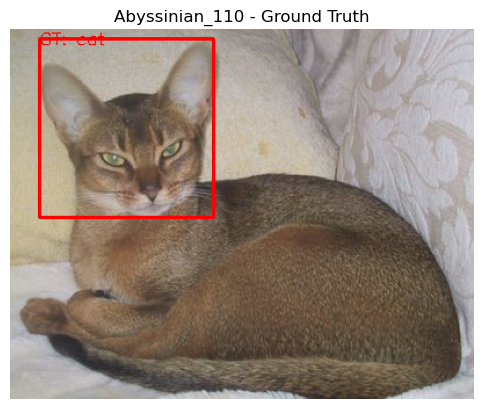

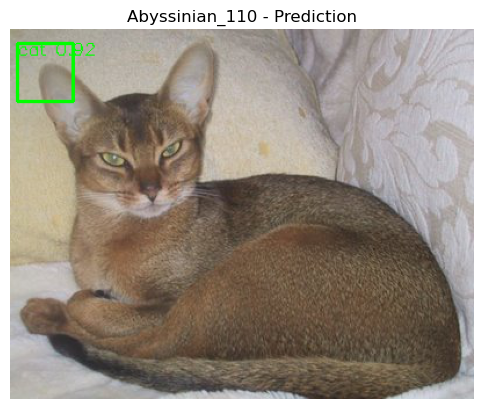

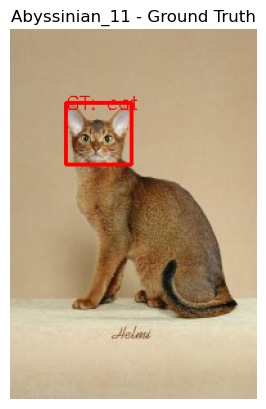

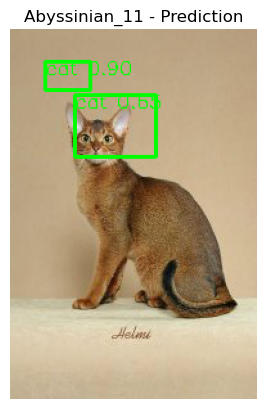

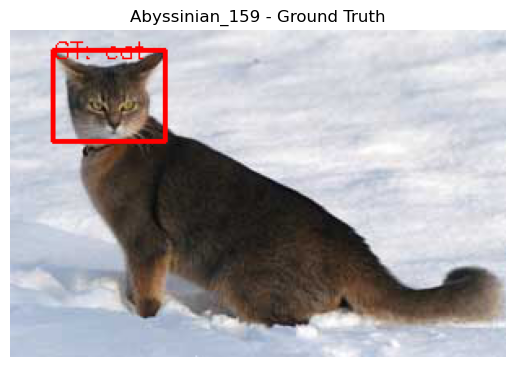

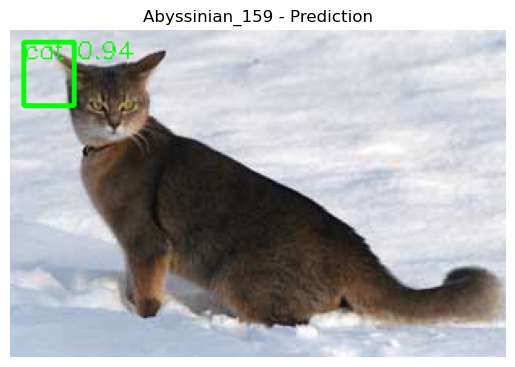

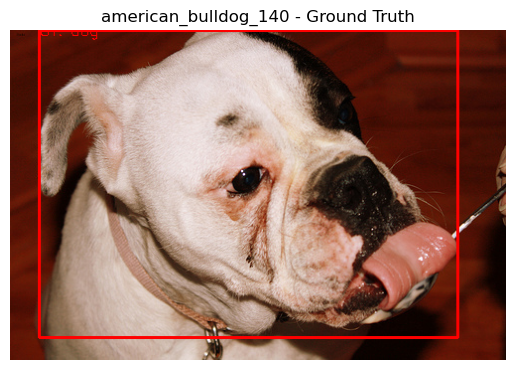

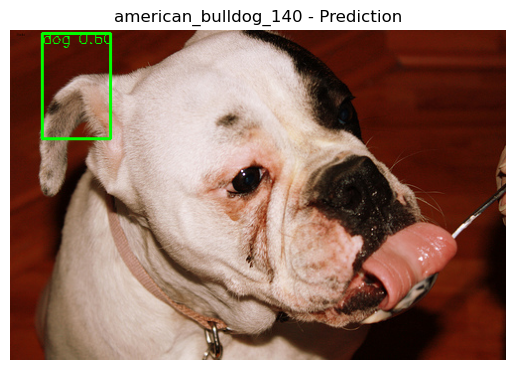

In [ ]:
import os
import cv2
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import xml.etree.ElementTree as ET

# ----- Config -----
IMAGE_DIR = "dataset/images"
ANNOTATION_DIR = "dataset/annotations/xmls"
MODEL_PATH = "model_best.pth"
IMAGE_NAMES = [
    "Abyssinian_110", "Abyssinian_11", "Abyssinian_159", 
    "american_bulldog_140"]

CLASS_MAP = {1: "cat", 2: "dog"}
NUM_CLASSES = 3 

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])


from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model(num_classes):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_feats = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, num_classes)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_model(NUM_CLASSES).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()

# Draw predicted bounding boxes
def draw_boxes(img, boxes, labels, scores, threshold=0.5):
    img = np.array(img)
    for box, label, score in zip(boxes, labels, scores):
        if score >= threshold:
            x1, y1, x2, y2 = map(int, box.tolist())
            cls_name = CLASS_MAP.get(label.item(), str(label.item()))
            text = f"{cls_name} {score:.2f}"
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, text, (x1, y1 + 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    return img
# Draw ground truth boxes from XML annotation
def draw_ground_truth(image_path, annotation_path):
    image = Image.open(image_path).convert("RGB")
    img = np.array(image)
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    for obj in root.findall("object"):
        name = obj.find("name").text
        box = obj.find("bndbox")
        x1 = int(float(box.find("xmin").text))
        y1 = int(float(box.find("ymin").text))
        x2 = int(float(box.find("xmax").text))
        y2 = int(float(box.find("ymax").text))
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img, f"GT: {name}", (x1, y1 + 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
    return img


for name in IMAGE_NAMES:
    image_path = os.path.join(IMAGE_DIR, f"{name}.jpg")
    annotation_path = os.path.join(ANNOTATION_DIR, f"{name}.xml")
    
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).to(device)
    
    with torch.no_grad():
        prediction = model([input_tensor])[0]
    
    # Ground Truth
    gt_img = draw_ground_truth(image_path, annotation_path)
    plt.imshow(gt_img)
    plt.title(f"{name} - Ground Truth")
    plt.axis("off")
    plt.show()

    # Prediction 
    pred_img = draw_boxes(image, prediction['boxes'], prediction['labels'], prediction['scores'])
    plt.imshow(pred_img)
    plt.title(f"{name} - Prediction")
    plt.axis("off")
    plt.show()



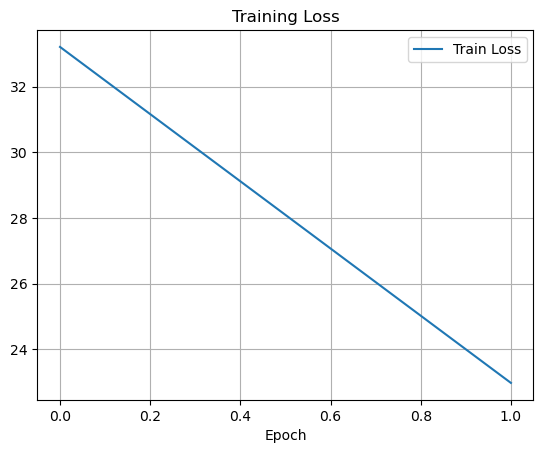

In [142]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.title("Training Loss")
plt.legend()
plt.grid(True)
plt.show()